# 2. Topologycal Analysis

In [ ]:
import praw
import pandas as pd
import json
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx

# load
df_general = pd.read_csv('../data/aot_general.csv')
df_ending = pd.read_csv('../data/aot_ending.csv')
df_general['created_utc'] = pd.to_datetime(df_general['created_utc'])
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

In [2]:
# login with your reddit credentials

def login_reddit(reddit_credentials):
    with open(reddit_credentials, "r") as f:
        credentials = json.load(f)

    reddit = praw.Reddit(
        client_id=credentials['CLIENT_ID'],
        client_secret=credentials['SECRET_TOKEN'],
        password=credentials['PASSWORD'],
        user_agent='Tutorial by /user/SMA202324',
        username=credentials['USERNAME'],
        check_for_async=False
    )

    if reddit.read_only:
        print("Reddit login failed. Please check your credentials.")
        return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}")
        return reddit
    
reddit_credentials = "../data/redditCredentials.json"
reddit = login_reddit(reddit_credentials)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


🤖 Reddit login successful. Welcome Disastrous_Walk_7254


In [3]:
df_general.head()

,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,poll_data,saved,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url
0,FoxicalOW,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-14 16:21:28,NaN,False,kx7nlm,True,False,...,NaN,False,29138,NaN,False,False,attackontitan,I built Shiganshina in Minecraft 1:1,0.99,https://i.redd.it/zlx4dtb7fbb61.jpg
1,kinekocat,Potato Girl Enjoyer :sasha_potato:,False,<praw.models.comment_forest.CommentForest obje...,2025-02-17 20:25:34,NaN,False,1irsbx6,False,False,...,NaN,False,26700,NaN,False,False,attackontitan,How do I even react to this??,0.98,https://i.redd.it/c7jyj8d23rje1.jpeg
2,ProfessorRigby,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-25 07:36:27,NaN,False,l4hxj7,False,False,...,NaN,False,24543,NaN,False,False,attackontitan,"Dad: ""Stop watching those stupid cartoons!"" Tw...",0.99,https://v.redd.it/7ewif8yjbfd61
3,NaN,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-10-05 22:44:40,NaN,False,q2569s,False,False,...,NaN,False,23331,NaN,False,False,attackontitan,well?,0.97,https://i.redd.it/ai437vhk1pr71.jpg
4,Psplus01,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-02-01 11:14:59,NaN,False,la0032,False,False,...,NaN,False,22645,NaN,False,False,attackontitan,Eren vs Annie in a nutshell,0.98,https://i.redd.it/oulo1tczcue61.jpg


In [5]:
def get_comments(df):
    # get comments till the third level

    res = []
    for index, i in df.iterrows():
        # Find author and comments
        sub_auth= i['author']
        sub= reddit.submission(i['id'])
        sub.comments.replace_more(limit=20)
        # Extract author for each comment
        for top_level_comment in sub.comments:
            # author of the top level comment
            top_l_auth = top_level_comment.author
            res.append({
                'parent': str(sub_auth), 
                'child': str(top_l_auth), 
                'text_comment': top_level_comment.body
            })
            # replies - second level comments
            for second_level_comment in top_level_comment.replies:
                # again we get the authors of the replies and create the pairs we are interested in 
                sec_l_auth = second_level_comment.author
                res.append({
                    'parent': str(top_l_auth), 
                    'child': str(sec_l_auth), 
                    'text_comment': second_level_comment.body
                })
                # replies of the repleis - third level comments
                for third_level_comment in second_level_comment.replies:
                    res.append({
                        'parent': str(sec_l_auth), 
                        'child': str(third_level_comment.author), 
                        'text_comment': third_level_comment.body
                    })
    return pd.DataFrame(res)

In [ ]:
comments_df_general = get_comments(df_general)
comments_df_general.to_csv('../data/comments_graph_general.csv', index=False)
comments_df_ending = get_comments(df_ending)
comments_df_ending.to_csv('../data/comments_graph_ending.csv', index=False)
print("length of comments df general: ", len(comments_df_general))
print("length of comments df ending: ", len(comments_df_ending))

## General

In [ ]:
G = nx.Graph()
for index, r in comments_df_general.iterrows():
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 17767 nodes and 30605 edges


In [11]:
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G_lcc.number_of_nodes()} nodes and {G_lcc.number_of_edges()} edges")

Size of the largest connected component: 17767 nodes and 30605 edges


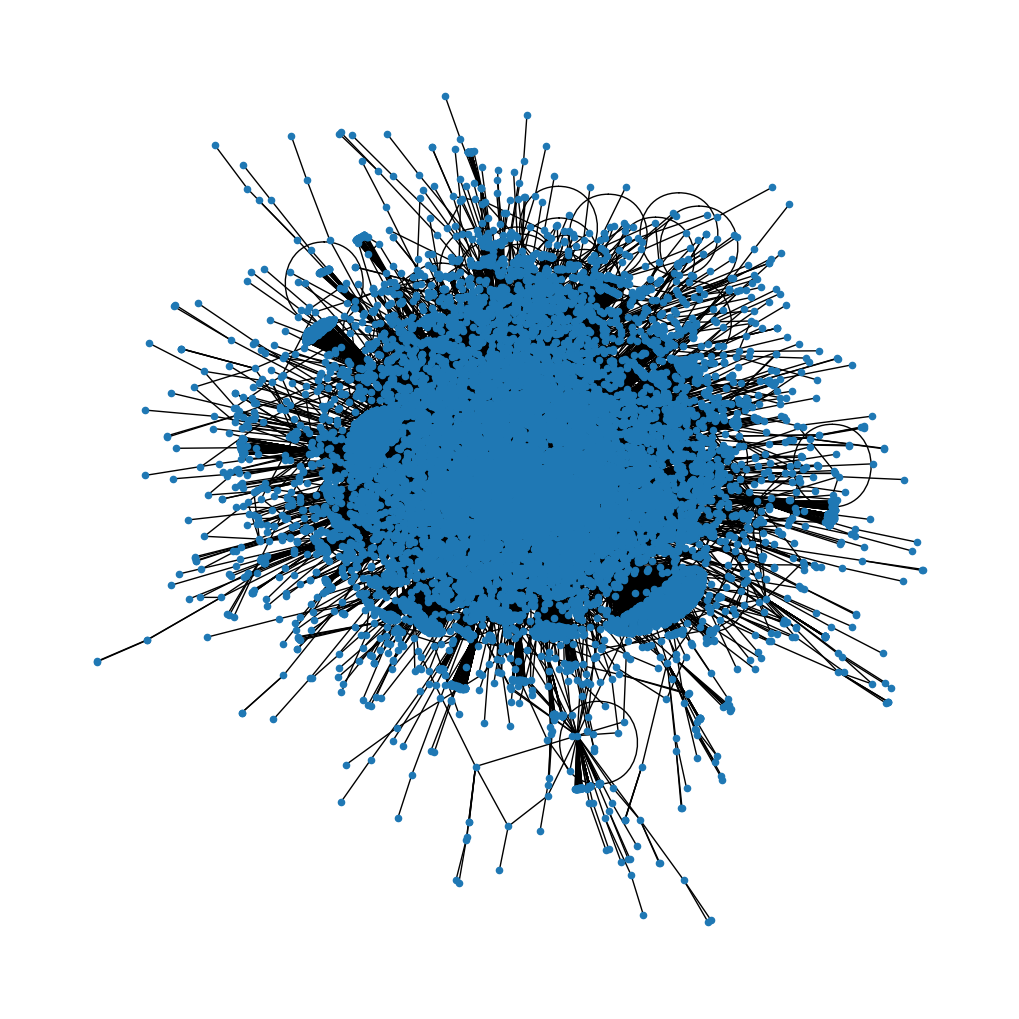

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_spring(G_lcc, node_size=10, with_labels=False)
plt.show()

# Ending

In [ ]:
G = nx.Graph()
for index, r in comments_df_general.iterrows():
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G_lcc.number_of_nodes()} nodes and {G_lcc.number_of_edges()} edges")

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_spring(G_lcc, node_size=10, with_labels=False)
plt.show()